<table style="width: 100%; border-style: none">
<tr style="border-style: none; background-color: #82a8cf">
<td style="border-style: none; width: 1%; text-align: left; font-size: 18px; color: #ffffff">Institut f&uuml;r Theoretische Physik<br /> <font color="#e6e6e6">Universit&auml;t zu K&ouml;ln </font></td>
<td style="border-style: none; width: 1%; font-size: 16px">&nbsp;</td>
<td style="border-style: none; width: 1%; text-align: right; font-size: 18px; color: #ffffff">Prof. Dr. Simon Trebst<br /> <font color="#e6e6e6"> Christoph Berke </font> </td>
</tr>
</table>
<hr  style="height: 2px; border-color: #606060; background-color: #606060"> 
<h1 style="font-weight:200; text-align: center; margin: 0px; font-size: 48px; padding:0px; color: #606060">Statistische Physik </h1>
<h1 style="font-weight:light; text-align: center; margin: 10px; padding:0px; color: #606060">&Uuml;bungsblatt 13</h1>
<hr  style="height: 2px; border-color: #606060; background-color: #606060"> 
<h3 style="font-weight:400; text-align: center; margin: 0px; font-size: 20px; padding:0px; margin-bottom: 20px; color: #606060">Wintersemester 23/24</h3>


<font size="4" color="#606060">**Website:** <a href="https://www.thp.uni-koeln.de/trebst/Lectures/2023-StatPhys.shtml" style="color:#82a8cf; text-decoration: underline;text-decoration-style: dotted;">https://www.thp.uni-koeln.de/trebst/Lectures/2023-StatPhys.shtml</a></font>

<font size="4" color="#606060">**Abgabe**: <span style="color:#82a8cf"> 22.01.2024, 10:00 Uhr </span> <span style="float:right;">**Besprechung**: 23.01.2024 </span></font>

<font size="4" color="#606060">**Name**: <span style="color:#82a8cf"> Bitte geben Sie Ihren Namen an.  </span> </font>

<table style="border-style: none; width: 100%; background-color: #FFFFFF"><tr style="border-style: none;">
<td style="border-style: none; width:3%; text-align: left; font-size: 25px; font-weight: 200;background-color: #FFFFFF">Aufgabe 44: Idealer Paramagnet </td>
<td style="border-style: none; width: 1%; text-align: right; font-size: 15px;background-color: #FFFFFF">[11 Punkte]</td></tr></table> 

### f) Magnetisierung mit Monte-Carlo

In diesem Aufgabenteil sollen Sie die analytischen Resultate für die Magnetisierung $M$ aus Teil c) numerisch überprüfen. Gleichzeitig können Sie sich mit den Programmteilen vertraut machen, die auf dem nächsten Aufgabenblatt zur Untersuchung des komplizierteren **Ferromagneten** benötigt werden.

Hier betrachten wir aber wieder den wechselwirkungsfreien **Paramagneten** und führen zunächst eine alternative, weitverbreitete Notation für den Hamiltonoperator ein. Wir schreiben Gleichung (2) vom Aufgabenblatt als 

\begin{equation}
    H = -h \sum_{\alpha} \sigma_\alpha \,.
\end{equation}

Wir haben also den Spin $S_\alpha$ mit Eigenwerten $\pm\frac{1}{2}$ durch $\sigma_\alpha =  \pm 1$ ersetzt und alle übrigen Faktoren in dem effektiven Magnetfeld $h$ zusammengefasst.
Die Summe läuft über alle Plätze $\alpha$ eines Gitters. In dieser Aufgabe betrachten wir das unten gezeigte Quadratgitter, der Index $\alpha$ bezeichnet also ein Tupel $\alpha = (i,j)$, das einen Gitterplatz eindeutig festlegt. Natürlich spielt die Gittergeometrie für den wechselwirkungsfreien Paramagneten mit voneinander unabhängigen Spins keine Rolle. In der nächsten Woche ergänzen wir dann aber Wechselwirkungen zwischen Gitternachbarn und die Geometrie wird relevant.

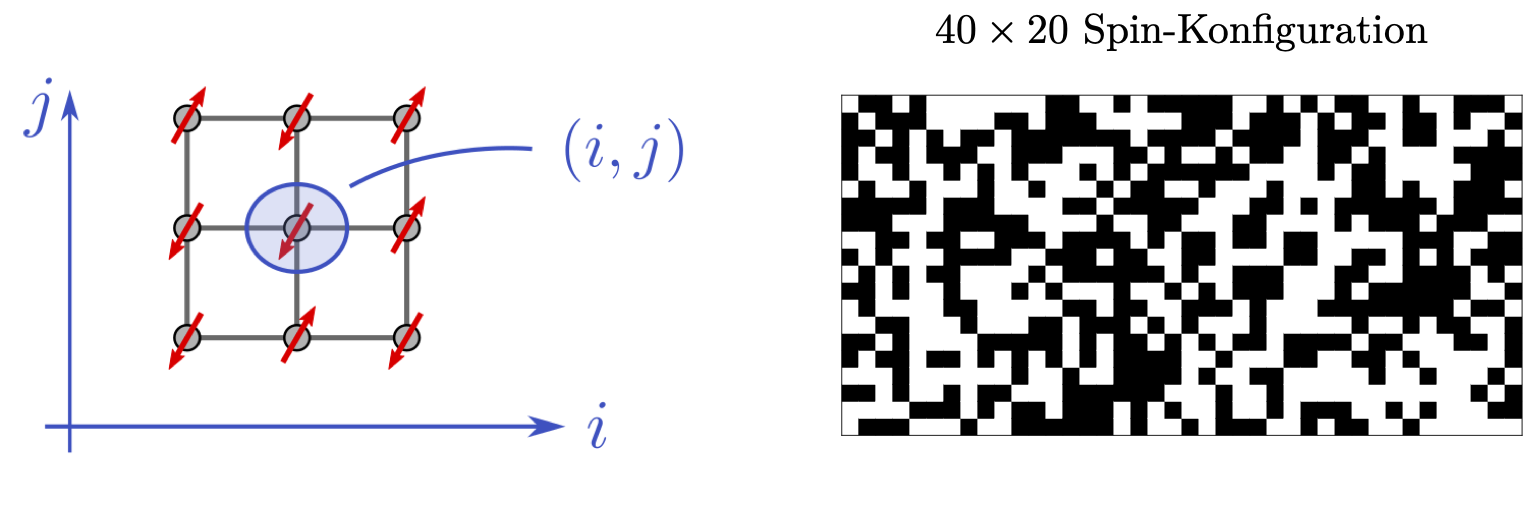

Der Paramagnet soll jetzt mittels einer Monte-Carlo-Simulation untersucht werden. In der Computer-Physik haben Sie den Metropolis-Algorithmus kennengelernt, dessen Implementierung wir Ihnen vorgeben (siehe auch das 9. Programmier-Tutorium zur Computerphysik im vergangenen Sommersemester).

### 1. Vorbereitung: Erzeugen und Darstellen von Spin-Konfigurationen

Wir implementieren zunächst Funktionen, die einzelne Spins mit zufälliger Orientierung, sowie Spinkonfigurationen auf dem Quadratgitter erzeugen und darstellen. Führen Sie die nachfolgenden Zellen aus.

In [ ]:
# Erzeuge zufälligen Spin ±1
function get_Ising_spin()
    # Prüfe ob Zufallszahl zwischen 0 und 1 größer als 0.5 ist.
    if rand() > 0.5
        return +1 # 50 %
    else
        return -1 # 50 %
    end
end

# Erzeuge Lx×Ly-Array aus zufälligen Spins.
function get_Ising_spins(Lx, Ly)
    return [get_Ising_spin() for i in 1:Lx, j in 1:Ly]
end

In [ ]:
using CairoMakie

# Stelle Spin-Array spins als Heatmap dar.
function plot_Ising_spins(spins)
    
    fig = Figure()
    ax = Axis(fig[1,1], aspect = DataAspect())
    hmap = heatmap!(ax, spins, colormap =:binary, colorrange = (0,1))  
    hidedecorations!(ax)

    return fig, ax, hmap
end

In [ ]:
# Beispiel:
Lx, Ly = 100, 100
f, a, hm = plot_Ising_spins(get_Ising_spins(Lx, Ly))
f

### 2. Implementierung des Metropolis-Algorithmus

Wir benötigen zwei Zutaten für den Metropolis-Algorithmus:
1. Eine Update-Vorschrift, um von einer Konfiguration der Markov-Kette in die nächste überzugehen.
2. Die Energiedifferenz $\Delta E$ der Konfigurationen nach und vor diesem Update.

Zur Erinnerung: Beim Metropolis-Algorithmus werden Update-Vorschläge immer akzeptiert wenn der neue Zustand energetisch günstiger ist ($\Delta E < 0$) und mit Wahrscheinlichkeit $\exp(-\Delta E / T)$ akzeptiert, wenn der neue Zustand eine höhere Energie hat.

Als einfachste Möglichkeit eines Updates betrachten wir das Flippen eines einzelnen Spins am Gitterplatz $\beta$: $\sigma_{\beta}\to \sigma\prime_\beta= -\sigma_\beta$. Damit ist die Energiedifferenz

\begin{equation}
    \Delta E = E_\text{nachher} - E_\text{vorher} = -h \left(\sum_{\alpha} \sigma\prime_\alpha - \sum_{\alpha}  \sigma_\alpha \right) = 2 h \sigma_\beta \,.
\end{equation}

Man beachte, dass zur Berechnung der Energiedifferenz die Gesamtenergie der Spin-Konfiguration nicht bekannt sein muss. 

Wir fassen hier $N$ Spin-Flip-Updatevorschläge eines System aus $N$ Spins zu einem sogenannten *Sweep* zusammen und messen die Magnetisierung immer nur nach einem ganzen Sweep.

In [ ]:
# Single spin flip update.
function update_SSF!(spins, h, T)
    
    # Update vorschlagen: Zufälligen Spin wählen.
    i = rand(1:size(spins, 1))
    j = rand(1:size(spins, 2))
    
    # Energiedifferenz berechnen.
    dE = 2 * h * spins[i,j]
    
    # Akzeptiere Update immer wenn dE < 0 und 
    # mit Wahrscheinlichkeit exp(-dE / T) wenn dE > 0.
    if rand() < exp(-dE / T)
        spins[i,j] *= -1 # Spin flip
        return
    else
        return # No spin flip
    end
end

# Ein Sweep = Anzahl der Spins Update-Versuche.
function sweep_SSF!(spins, h, T)
    # Anzahl spins an Update vorschlagen
    for u in 1:length(spins)
        update_SSF!(spins, h, T)
    end
end

In [ ]:
# Magnetisierung
function get_magnetization(spins)
    return sum(spins)
end

### 3. Testen der Implementierung

In der nächsten Zelle wird eine Spin-Konfigurationen zunächst für 100 Sweeps thermalisiert (sodass der Gleichgewichtszustand erreicht wird) und anschließend die Magnetisierung nach jedem von 100 weiteren Sweeps gemessen. Die finale Konfiguration wird dargestellt. Führen Sie die Zelle aus und untersuchen Sie auch andere Werte von $\frac{h}{T}$, insbesondere $\frac{h}{T} \ll 1$ und $\frac{h}{T} \gg 1$.

In [ ]:
# Magnetfeld und Temperatur.
h, T = 0.8, 1

# Anfangskonfiguration erzeugen (100 × 100 Spins).
L = 200
spins = get_Ising_spins(L, L)

# Thermalisierung: 100 Sweeps durchführen
for _ in 1:100
    sweep_SSF!(spins, h, T)
end

# Messung der Magnetisierung: 100 weitere Sweeps
m_vals = zeros(100) # Array für Magnetisierung pro Spin

for i in 1:100
    sweep_SSF!(spins, h, T)
    m_vals[i] = get_magnetization(spins) / L^2
end

# Mittlere Magnetisierung pro Spin
m_mean = sum(m_vals)/100

# Darstellen der Endkonfiguration
with_theme(theme_latexfonts()) do
    f, a, hm = plot_Ising_spins(spins)
    a.title = "Mittlere Magnetisierung pro Spin: $(round(m_mean, digits = 4))"
    f
end

### 4. Magnetisierung $M$ als Funktion des Magnetfeldes $h$

#### Jetzt sind Sie dran:
Berechnen Sie für alle unten vorgegebenen Temperaturen $T$ die Magnetisierung pro Spin als Funktion der Feldstärke, also $M_T(h)$. Stellen Sie die entstehende Funktionenschar in einem gemeinsamen Plot dar. Ergänzen Sie in Ihrer Abbildung außerdem die analytischen Ergebnisse aus Aufgabenteil c). 

*Hinweise:*
Betrachten Sie ein Quadratgitter aus $40 \times 40$ Spins. Führen Sie für jede neue Parameterwahl zunächst $500$ Sweeps durch, um das System thermalisieren zu lassen und anschließend $500$ weitere Sweeps, nach denen jeweils die Magnetisierung gemessen wird. 

In [ ]:
# Temperaturen und Feldstärken.
Ts = exp10.(range(-1,2,length = 10))
hvals = range(-10.0, 10.0, length=31)